In [1]:
import os
import sys

os.chdir('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
sys.path.append("Marigold")

## Vanilla Generation

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, DPMSolverMultistepScheduler, RePaintScheduler, RePaintPipeline
# DPMSolverMultistepScheduler
from model import init_marigold, run_marigold
from src.utils.depth_utils import get_scaled_depth_sparse, compute_scale_and_shift

data_path = "/data2/wlsgur4011/SparseDC/datas/cache/1.marigold(vanilla)_a8b9d00ddfebe9d72ec8a22fdb190230.pt"
data = torch.load(data_path)

depth_pred = data['depth_pred']
depth_gt = data['gt'][0][0]
depth_gt_sparse = data['dep'][0][0]


In [3]:
depth_sparse_scaled = get_scaled_depth_sparse(depth_pred, depth_gt_sparse)

In [4]:

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
marigold = init_marigold()


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from diffusers import DDIMScheduler

latent_list = []

class BackPropRepaintScheduler(DDIMScheduler):

    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)


    def _backprob_inpaint(self, x0_pred, lr=2., num_iter=10):
        if hasattr(self, 'vae') and hasattr(self, 'sparse_depth'):
            import jhutil; jhutil.jhprint(1111, )
            for i in range(num_iter):
                x0_pred.requires_grad = True

                with torch.enable_grad():                    
                    
                    depth_latent = x0_pred / self.vae.config.scaling_factor
                    # decode
                    z = self.vae.post_quant_conv(depth_latent)
                    stacked = self.vae.decoder(z)
                    # mean of output channels
                    depth = stacked.mean(dim=1, keepdim=True)
                    depth = depth.squeeze()
                    
                    # shift to [0, 1]
                    depth = (depth + 1.0) / 2.0
                    
                    # rmse loss
                    loss = torch.sqrt(torch.sum((depth - self.sparse_depth)[self.sparse_depth != 0] ** 2))
                    import jhutil; jhutil.jhprint(2222, loss)
                    grads = torch.autograd.grad(outputs=loss, inputs=x0_pred)[0]
                x0_pred = x0_pred - lr * grads
        
        latent_list.append(x0_pred)
        return x0_pred
    
    def add_vae(self, vae):
        vae.requires_grad = True
        self.vae = vae
        
    def add_sparse_depth(self, depth_pred, depth_gt_sparse):
        sparse_depth_scaled = self.get_scaled_depth_sparse(depth_pred, depth_gt_sparse)
        self.sparse_depth = self.resize_sparse_depth_map(sparse_depth_scaled)
        self.sparse_depth.requires_grad = True

    def resize_sparse_depth_map(self, sparse_depth_map, h2=576, w2=768):
        device = sparse_depth_map.device
        h1, w1 = sparse_depth_map.shape
        assert h1 <= h2 and w1 <= w2, "New shape must be larger than the original shape."
        
        # Find the indices and values of the non-zero elements
        nz_indices = sparse_depth_map.nonzero()
        nz_values = sparse_depth_map[nz_indices[:, 0], nz_indices[:, 1]]
        
        # Calculate new positions based on linear interpolation
        nz_indices_float = nz_indices.float()
        new_i = nz_indices_float[:, 0] * (h2 - 1) / (h1 - 1)
        new_j = nz_indices_float[:, 1] * (w2 - 1) / (w1 - 1)
        
        # Round the positions to nearest integer (optional, depending on how you want to handle subpixel locations)
        new_i = new_i.round().long()
        new_j = new_j.round().long()
        
        # Create a new depth map with zeros
        new_depth_map = torch.zeros((h2, w2), dtype=sparse_depth_map.dtype, device=device)
        
        # Place the sparse values into the new depth map
        new_depth_map[new_i, new_j] = nz_values
        
        return new_depth_map

    
    def get_scaled_depth_sparse(self, depth_pred, depth_gt_sparse):
        if depth_pred.ndim == 3:
            depth_pred = depth_pred.squeeze(0)
        if depth_gt_sparse.ndim == 3:
            depth_gt_sparse = depth_gt_sparse.squeeze(0)

        mask = depth_gt_sparse != 0
        scale, shift = compute_scale_and_shift(depth_pred[None, :], depth_gt_sparse[None, :], mask[None, :])
        scaled_depth_sparse = (depth_gt_sparse - shift) / scale
        scaled_depth_sparse[~mask] = 0

        return scaled_depth_sparse

config = {
    'num_train_timesteps': 1000,
    'beta_start': 0.00085,
    'beta_end': 0.012,
    'beta_schedule': 'scaled_linear',
    'trained_betas': None,
    'clip_sample': False,
    'set_alpha_to_one': False,
    'steps_offset': 1,
    'prediction_type': 'v_prediction',
    'thresholding': False,
    'dynamic_thresholding_ratio': 0.995,
    'clip_sample_range': 1.0,
    'sample_max_value': 1.0,
    'timestep_spacing': 'leading',
    'rescale_betas_zero_snr': False,
}

scheduler = BackPropRepaintScheduler(**config)

scheduler.add_sparse_depth(depth_pred, depth_gt_sparse)
scheduler.add_vae(marigold.vae)

marigold.scheduler = scheduler

In [6]:
# 2. load data

import torch
from torchvision import transforms


my_image_tensor = data['rgb'][0].cpu()
my_image = transforms.ToPILImage()(my_image_tensor)
depth_guide = run_marigold(marigold, my_image, use_cache=False, store_cache=False, ensemble_size=1, denoise_steps=20)

1111 
2222  "tensor grad SqrtBackward0 cuda:0 1.439"
2222  "tensor grad SqrtBackward0 cuda:0 1.380"
2222  "tensor grad SqrtBackward0 cuda:0 1.317"
2222  "tensor grad SqrtBackward0 cuda:0 1.255"
2222  "tensor grad SqrtBackward0 cuda:0 1.200"
2222  "tensor grad SqrtBackward0 cuda:0 1.146"
2222  "tensor grad SqrtBackward0 cuda:0 1.093"
2222  "tensor grad SqrtBackward0 cuda:0 1.041"
2222  "tensor grad SqrtBackward0 cuda:0 0.989"
2222  "tensor grad SqrtBackward0 cuda:0 0.939"
1111 
2222  "tensor grad SqrtBackward0 cuda:0 1.448"
2222  "tensor grad SqrtBackward0 cuda:0 1.388"
2222  "tensor grad SqrtBackward0 cuda:0 1.324"
2222  "tensor grad SqrtBackward0 cuda:0 1.260"
2222  "tensor grad SqrtBackward0 cuda:0 1.203"
2222  "tensor grad SqrtBackward0 cuda:0 1.148"
2222  "tensor grad SqrtBackward0 cuda:0 1.095"
2222  "tensor grad SqrtBackward0 cuda:0 1.043"
2222  "tensor grad SqrtBackward0 cuda:0 0.993"
2222  "tensor grad SqrtBackward0 cuda:0 0.943"
1111 
2222  "tensor grad SqrtBackward0 cuda:0 1.

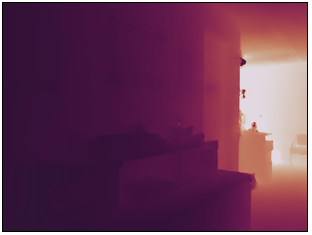

In [8]:
depth_guide.chans

1111  "tensor[359] 1.4Kb x∈[7.081e-05, 0.941] μ=0.061 σ=0.096 cuda:0"
2222  "tensor[359] 1.4Kb x∈[1.514e-05, 2.438] μ=0.216 σ=0.373 cuda:0"
1111  "tensor[228, 304] n=69312 (0.3Mb) x∈[1.001e-05, 3.121] μ=0.167 σ=0.180 cuda:0"
2222  "tensor[228, 304] n=69312 (0.3Mb) x∈[7.629e-06, 3.112] μ=0.183 σ=0.215 cuda:0"


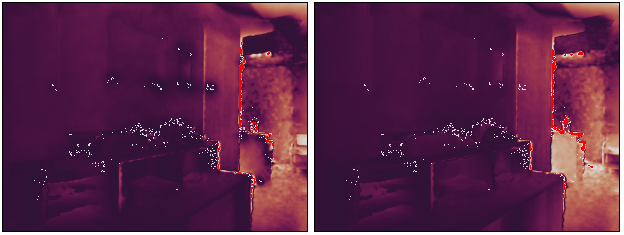

In [7]:
def compare_affine_and_guidence(depth_affine, depth_guide, depth_gt, depth_gt_sparse):
    mask = depth_gt_sparse != 0
    scale, shift = compute_scale_and_shift(depth_affine[None, :], depth_gt_sparse[None, :], mask[None, :])
    depth_affine_rescaled = depth_affine * scale + shift
    diff_affine = torch.abs(depth_affine_rescaled - depth_gt)
    
    scale, shift = compute_scale_and_shift(depth_guide[None, :], depth_gt_sparse[None, :], mask[None, :])
    depth_guide_rescaled = depth_guide * scale + shift
    diff_guide = torch.abs(depth_guide_rescaled - depth_gt)
    
    
    diff_guide[mask] = -1
    diff_affine[mask] = -1
    return torch.stack([diff_guide, diff_affine]).chans

compare_affine_and_guidence(depth_pred, depth_guide, depth_gt, depth_gt_sparse)

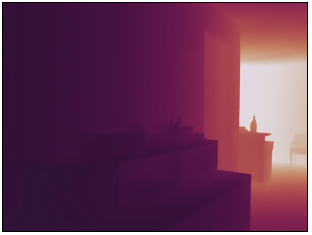

In [10]:
depth_pred.chans